## CRF model

Modelo CRF para ato de aviso de licitação (com dados rotulados manualmente)

In [ ]:
# !pip install sklearn_crfsuite
import pandas as pd
import sklearn_crfsuite
import nltk
from nltk.tokenize import word_tokenize

: 

In [143]:
df= pd.read_csv('result_aviso_licitacao.csv')
result = pd.DataFrame(df)
result.tokenized_text = result.tokenized_text.apply(lambda x: x.encode('ascii','ignore'))

In [144]:
result['tokenized_text'][0].decode("utf-8").replace("', '", '').replace("[' ", '').replace("']", '')

'O O O B-MODALIDADE_LICITACAO I-MODALIDADE_LICITACAO O B-NUM_LICITACAO O O B-PROCESSO O O O B-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO I-OBJ_LICITACAO B-TIPO_OBJ I-TIPO_OBJ I-TIPO_OBJ I-TIPO_OBJ I-TIPO_OBJ O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-VALOR_ESTIMADO I-VALOR_ESTIMADO I-VALOR_ESTIMADO O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-CODIGO_SISTEMA_COMPRAS O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-SISTEMA_COMPRAS O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O'

Load csv with text and labels

In [ ]:
x = []
y = []
for row in range(len(result)):
    if pd.notna(result['treated_text'][row]):
        text_iob = result['tokenized_text'][row].decode("utf-8").replace("', '", '').replace("[' ", '').replace("']", '')
        x.append(tokenizer.tokenize(result['treated_text'][row]))
        y.append(text_iob.split())
len(x), len(y)

: 

In [146]:
# Tirando os rotulos que nao batem com os dados
continua = True
while continua == True:
    continua = False
    for i in range(len(x)):
        if len(x[i]) > len(y[i]):
            x[i].pop()
            continua = True

        if len(x[i]) < len(y[i]):
            y[i].pop()
            continua = True

Create dictionary feature for each word in each sequence in x

In [147]:
def get_features(sentence):
        """Create features for each word in act.
        Create a list of dict of words features to be used in the predictor module.
        Args:
            act (list): List of words in an act.
        Returns:
            A list with a dictionary of features for each of the words.
        """
        sent_features = []
        for i in range(len(sentence)):
            word_feat = {
                'word': sentence[i].lower(),
                'word[-3:]': sentence[i][-3:],
                'word[-2:]': sentence[i][-2:],
                'capital_letter': sentence[i][0].isupper(),
                'word_istitle': sentence[i].istitle(),
                'all_capital': sentence[i].isupper(),
                'word_isdigit': sentence[i].isdigit(),
                'word_before': '' if i == 0 else sentence[i-1].lower(),
                'word_before_isdigit': '' if i == 0 else sentence[i-1].isdigit(),
                'word_before_isupper': '' if i == 0 else sentence[i-1].isupper(),
                'word_before_istitle': '' if i == 0 else sentence[i-1].istitle(),
                'word_after:': '' if i+1 >= len(sentence) else sentence[i+1].lower(),
                'word_after_isdigit:': '' if i+1 >= len(sentence) else sentence[i+1].isdigit(),
                'word_after_isupper:': '' if i+1 >= len(sentence) else sentence[i+1].isupper(),
                'word_after_istitle:': '' if i+1 >= len(sentence) else sentence[i+1].istitle(),
                'BOS': i == 0,
                'EOS': i == len(sentence)-1
            }
            sent_features.append(word_feat)
        return sent_features
    
for i in range(len(x)):
    x[i] = get_features(x[i])

Separate train and test splits (in order)

In [148]:
import math
split_idx = math.floor(0.8*len(x))
x_train = x[0:split_idx]
y_train = y[0:split_idx]
x_test = x[split_idx:]
y_test = y[split_idx:]
len(x_train),  len(x_test), len(y_train)


(188, 47, 188)

In [149]:
# !pip install scipy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV


crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)

params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

rs = RandomizedSearchCV(crf, params_space, 
                        cv=5, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50)
rs.fit(x_train, y_train)

/home/thais/Documentos/Knedle/venv/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  5.9min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98d5c56fa0>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98d5c56400>},
                   verbose=1)

In [150]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.172277893821461, 'c2': 0.17230888367230024}
best CV score: 0.9373763893335019
model size: 0.30M


Dark blue => 0.9284, dark red => 0.9374


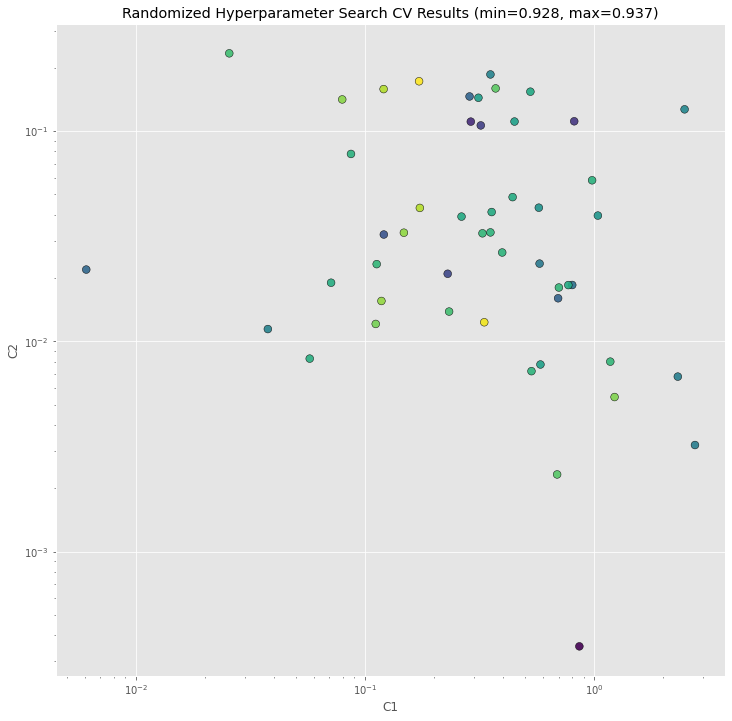

In [151]:
# !pip install matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
plt.style.use('ggplot')

_x = rs.cv_results_['param_c1']
_y = rs.cv_results_['param_c2']
_c = rs.cv_results_['mean_test_score']

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [166]:
crf = rs.best_estimator_

classes = list(crf.classes_)
classes.remove('O')

y_pred = crf.predict(x_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=classes, digits=3
))

                          precision    recall  f1-score   support

  B-MODALIDADE_LICITACAO      1.000     0.830     0.907        47
  I-MODALIDADE_LICITACAO      1.000     0.796     0.886        49
         B-NUM_LICITACAO      0.872     0.891     0.882        46
              B-PROCESSO      0.000     0.000     0.000        48
         B-OBJ_LICITACAO      0.000     0.000     0.000         1
         I-OBJ_LICITACAO      0.000     0.000     0.000         6
              B-TIPO_OBJ      0.000     0.000     0.000         2
              I-TIPO_OBJ      0.000     0.000     0.000         1
        B-VALOR_ESTIMADO      0.000     0.000     0.000        16
        I-VALOR_ESTIMADO      0.000     0.000     0.000         2
B-CODIGO_SISTEMA_COMPRAS      0.000     0.000     0.000         6
       B-SISTEMA_COMPRAS      0.526     0.333     0.408        30
         B-DATA_ABERTURA      0.800     0.190     0.308        42
         I-DATA_ABERTURA      0.931     0.325     0.482        83
       B-

In [167]:
from collections import Counter

def print_transitions(trans_features):
    # print(list(trans_features))
    for (label_from, label_to), weight in trans_features:
        # if not 'O' in label_from or 'O' not in label_to:
            # print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))
        

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
O      -> O       5.510030
I-OBJ_LICITACAO -> I-OBJ_LICITACAO 5.291924
I-SISTEMA_COMPRAS -> I-SISTEMA_COMPRAS 4.640225
I-TIPO_OBJ -> I-TIPO_OBJ 4.531007
I-DATA_ABERTURA -> I-DATA_ABERTURA 4.249091
B-TIPO_OBJ -> I-TIPO_OBJ 4.086054
I-VALOR_ESTIMADO -> I-VALOR_ESTIMADO 3.792919
I-PROCESSO -> I-PROCESSO 3.596817
O      -> B-PROCESSO 3.554533
I-ORGAO_LICITANTE -> I-ORGAO_LICITANTE 3.432894
B-MODALIDADE_LICITACAO -> I-MODALIDADE_LICITACAO 3.377692
O      -> B-VALOR_ESTIMADO 3.328390
O      -> B-DATA_ABERTURA 3.228145
O      -> B-SISTEMA_COMPRAS 3.198344
B-OBJ_LICITACAO -> I-OBJ_LICITACAO 3.160317
B-PROCESSO -> I-PROCESSO 2.827270
B-SISTEMA_COMPRAS -> I-SISTEMA_COMPRAS 2.731190
O      -> B-CODIGO_SISTEMA_COMPRAS 2.653185
I-OBJ_LICITACAO -> B-TIPO_OBJ 2.554736
B-ORGAO_LICITANTE -> I-ORGAO_LICITANTE 2.398209

Top unlikely transitions:
O      -> I-SISTEMA_COMPRAS -1.509968
B-SISTEMA_COMPRAS -> B-CODIGO_SISTEMA_COMPRAS -1.516390
I-PROCESSO -> B-PROCESSO -1.519143
I-ORGAO_

In [168]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
4.183201 B-SISTEMA_COMPRAS word_before:www.compras.df.gov.br
4.155416 B-DATA_ABERTURA word_after::às
3.967783 B-NUM_LICITACAO word_before:nº
3.707740 B-SISTEMA_COMPRAS word_before:www.licitacoes-e.com.br
3.494202 B-CODIGO_SISTEMA_COMPRAS word_before:)
3.349372 B-DATA_ABERTURA word:às
3.301431 B-DATA_ABERTURA word_before:às
3.185665 B-DATA_ABERTURA word_before:17/12/2009
3.077822 B-SISTEMA_COMPRAS word_after::pré-cadastro
3.044414 B-MODALIDADE_LICITACAO word_before:licitação
3.018451 B-TIPO_OBJ word_after::especializada
2.998662 B-SISTEMA_COMPRAS word_before:www.comprasnet.gov.br
2.957043 B-NUM_LICITACAO word_before:n.º
2.951460 B-SISTEMA_COMPRAS word_before:www.fazenda.df.gov.br
2.864215 B-CODIGO_SISTEMA_COMPRAS word_before:uasg
2.848882 B-SISTEMA_COMPRAS word_before:www.comprasgovernamentais.gov.br
2.712402 B-PROCESSO word_before:processo
2.671490 B-VALOR_ESTIMADO word_before:$
2.656141 B-CODIGO_SISTEMA_COMPRAS word_after::a
2.564933 B-NUM_LICITACAO word_before:eletrônic